In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np


dataset = load_dataset('ag_news')

def simple_tokenizer(text):
    return text.lower().replace("'", "").split()

from collections import Counter
counter = Counter()
for ex in dataset['train']:
    counter.update(simple_tokenizer(ex['text']))

vocab_size = 20000
most_common = [t for t,_ in counter.most_common(vocab_size - 2)]
vocab = {t:i+2 for i,t in enumerate(most_common)}
vocab['<pad>'] = 0; vocab['<unk>'] = 1

def encode(text):
    return [vocab.get(w,1) for w in simple_tokenizer(text)]

class NewsDataset(Dataset):
    def __init__(self, split): self.data = dataset[split]
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        txt = torch.tensor(encode(self.data[i]['text']),dtype=torch.long)
        lbl = self.data[i]['label']
        return txt, lbl

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    xs, ys = zip(*batch)
    lengths = [x.size(0) for x in xs]
    xs = pad_sequence(xs, batch_first=True, padding_value=0)
    return xs, torch.tensor(ys), lengths

loader = DataLoader(NewsDataset('train'), batch_size=128, shuffle=True, collate_fn=collate_fn)


train_size = int(0.9 * len(loader.dataset))
val_size = len(loader.dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(loader.dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=128, collate_fn=collate_fn)

In [49]:
class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks

        assert out_features % num_blocks == 0
        
        block_out_features = out_features // num_blocks
        
        self.blocks = nn.ModuleList([
            nn.Linear(in_features, block_out_features)
            for _ in range(num_blocks)
        ])
        
    def forward(self, x):
        x = [block(x) for block in self.blocks]
        x = torch.cat(x, dim=-1)
        return x

class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4/3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)

        self.Wz = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, self.hidden_size, num_heads)

        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

        self.up_proj_left = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(self.hidden_size * proj_factor), input_size)

    def forward(self, x, prev_state):
        assert x.size(-1) == self.input_size
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)
        
        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))

        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)

        # TODO !!!!
        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t) # Всегда <= 1.0
        f = torch.exp(f_tilde + m_prev - m_t) # Всегда <= 1.0

        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t

        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)
    
class sLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=4/3):
        super(sLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([sLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, self.hidden_size)
        self.down_proj = nn.Linear(self.hidden_size, input_size)

        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)
        
        assert x.size(-1) == self.input_size
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)

        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)

        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(x_up_left)

        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        c_t = f * c_prev + i * (v * k) # v @ k.T
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0] # o * (c @ q) / max{|n.T @ q|, 1}

        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)
    
class mLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=2):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([mLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class xLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, layers, batch_first=False, proj_factor_slstm=4/3, proj_factor_mlstm=2):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.layers = layers
        self.num_layers = len(layers)
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor_slstm
        self.proj_factor_mlstm = proj_factor_mlstm

        self.layers = nn.ModuleList()
        for layer_type in layers:
            if layer_type == 's':
                layer = sLSTMBlock(input_size, head_size, num_heads, proj_factor_slstm)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size, head_size, num_heads, proj_factor_mlstm)
            else:
                raise ValueError(f"Invalid layer type")
            self.layers.append(layer)

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

In [50]:
from tqdm import tqdm


class xLSTMWithEmbedding(nn.Module):
    def __init__(self, vocab_size, input_size=64, head_size=16, num_heads=3, layers =['m'] , num_classes=4, max_len=128, batch_first=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, input_size, padding_idx=0)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, input_size))
        self.xlstm = xLSTM(input_size, head_size, num_heads, layers, batch_first=batch_first)

        self.fc_out = nn.Linear(input_size, num_classes)
        self.hidden_states = []

    def forward(self, x, state=None):
        x = self.embedding(x)
        x, self.hidden_states = self.xlstm(x, state)
        x = x.mean(dim=1)
        logits = self.fc_out(x)
        return logits


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = xLSTMWithEmbedding(vocab_size=len(vocab), batch_first=True).to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

losses, accuracies = [], []

def evaluate(model, loader):
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for x,y,_ in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total


epochs = 5
for ep in range(epochs):
    model.train(); total_loss=0
    for x,y,_ in tqdm(train_loader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)
    losses.append(avg_loss)
    accuracies.append(val_acc)
    print(f"Epoch {ep+1}/{epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

100%|██████████| 844/844 [07:45<00:00,  1.81it/s]


Epoch 1/5, Loss: 0.9202, Val Acc: 0.7895


100%|██████████| 844/844 [07:40<00:00,  1.83it/s]


Epoch 2/5, Loss: 0.4854, Val Acc: 0.8402


100%|██████████| 844/844 [07:41<00:00,  1.83it/s]


Epoch 3/5, Loss: 0.3881, Val Acc: 0.8618


100%|██████████| 844/844 [07:43<00:00,  1.82it/s]


Epoch 4/5, Loss: 0.3349, Val Acc: 0.8738


100%|██████████| 844/844 [08:09<00:00,  1.72it/s]


Epoch 5/5, Loss: 0.2979, Val Acc: 0.8814


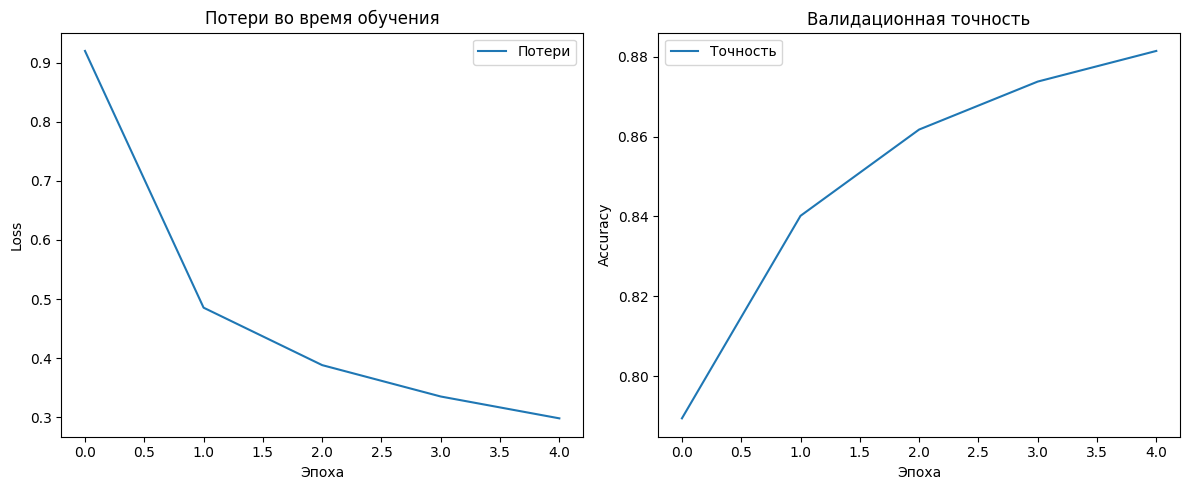

In [52]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses, label='Потери')
plt.title('Потери во время обучения')
plt.xlabel('Эпоха'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Точность')
plt.title('Валидационная точность')
plt.xlabel('Эпоха'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

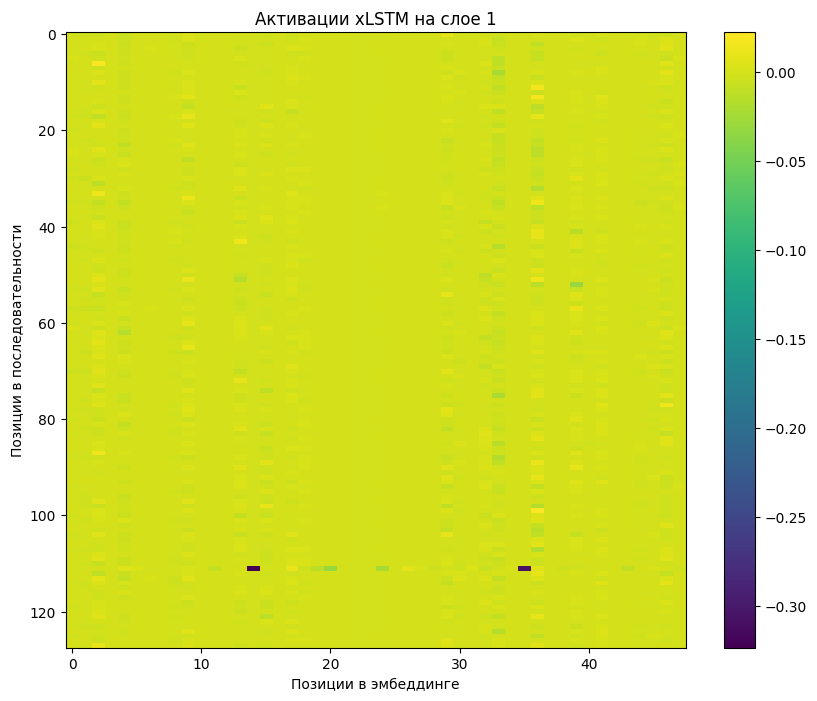

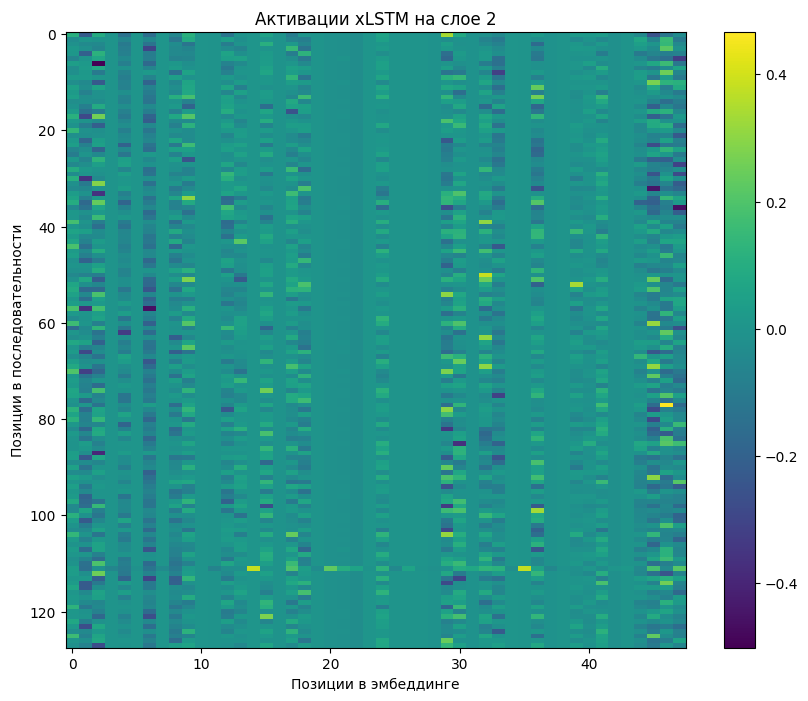

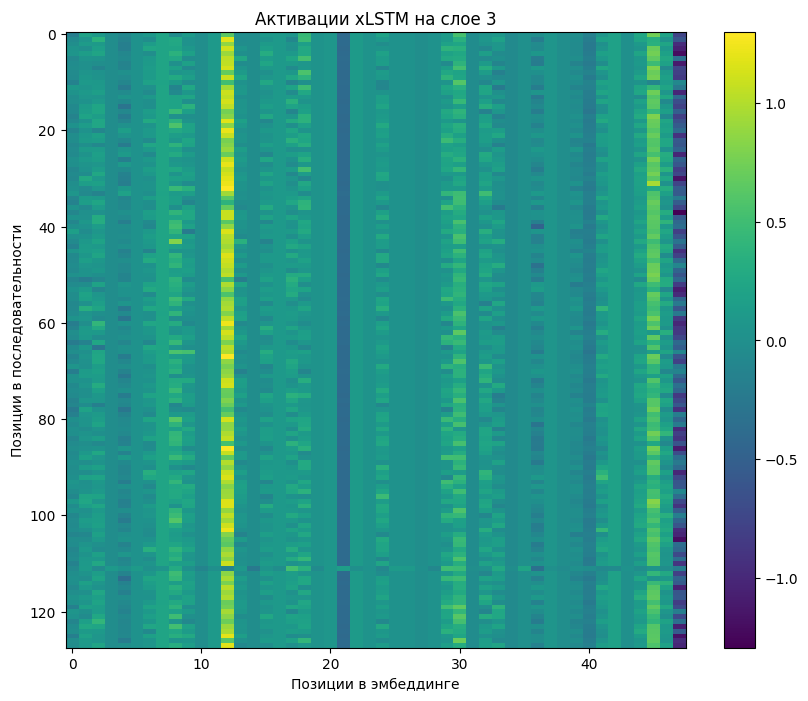

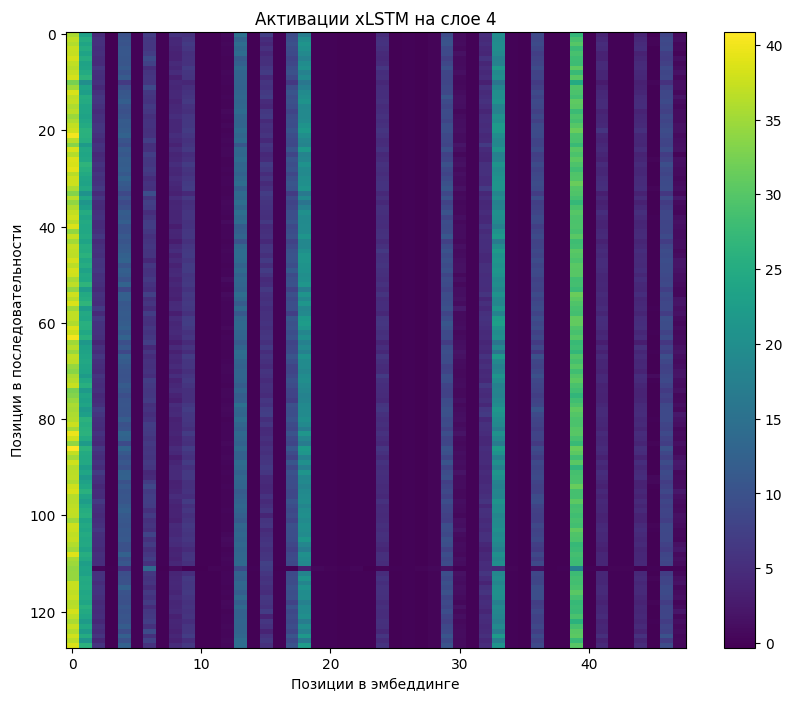

In [60]:
x, y, _ = next(iter(val_loader))
x = x.to(device)
_ = model(x)  # Заполняем model.hidden_states

for layer_idx, h in enumerate(model.hidden_states):
    activation = h.mean(dim=0).squeeze().cpu().detach().numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(activation, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Активации xLSTM на слое {layer_idx + 1}")
    plt.xlabel("Позиции в эмбеддинге")
    plt.ylabel("Позиции в последовательности")
    plt.show()

## Выводы

Модель довольно хрошо обучилась на решение задачи (acc = 0.88), получилось немного хуже чем mamba, также при одинаковых значениях лосса точность ощутимо хуже чем у mamba.

По весам внимания видим, что чем дальше слой, тем больше внимания на конкретные элементы эмбединга и все меньше на позицию в последовательности, что практически противоположно поведению на этой задаче mamba. Кроме того на каждом слледующем слое абсолютные значения весов внимания сильно увеличиваются.